### Outliers
Outliers are particularly problematic in linear regression due to the nature of the objective function. Linear regression tries to minimise the sum of the squared residuals; outliers may have very large residuals, which when squared make up a large proportion of the objective value. So linear models can be heavily influenced by the presence of outliers, to the detriment of their ability to predict non-outlier values. It is therefore important to identify outliers since they may distort the model.

In order to detect outliers we first need to define what we mean by an outlier. Intuitively, defining an outlier as a prediction which is very far away from all other predictions seems sensible. This idea of being far away from the other predictions is called leverage. However high leverage alone does not necessarily imply a point is an outlier. That is because, even if a point has high leverage, it may still sit very close to the extrapolated regression line and so might not actually exert much influence on the model. We define a point's influence as its leverage x residual. This captures the idea that a point not only needs to be far from other predictions, but also far from the regression line (i.e. high residual) to distort the model and therefore be considered an outlier. 

More technically we define leverage and influence as follows:

$$
leverage_i = \hat{y}_i - \frac{1}{n}\sum_{j=1}^n \hat{y}_j
$$

So the leverage of a given point is the difference between its fitted value and the average of all fitted values. 

$$
influence_i = leverage_i * residual_i = (\hat{y}_i - \frac{1}{n}\sum_{j=1}^n \hat{y}_j) * (\hat{y}_i - y_i)
$$

Cook's distance is used to detect outliers. It works by comparing the fitted values of a model including the given point with the fitted values of a model fit with the given point removed. So it effecitvely measures how much a given point is effecting the model.

$$
Cook's\;Distance_i = \frac{1}{p \hat{\sigma}^2}\sum_{j=1}^n (\hat{y}_j - \hat{y}_{j(i)})^2
$$

where
- $p$: number of model parameters including the intercept  
- $\hat{\sigma}^2$: estimated error variance  
- $\hat{y}_j$: fitted value using all data  
- $\hat{y}_{j(i)}$: fitted value when point i is omitted

Note that it can also be expressed in terms of the residuals and leverage as follows:

$$
Cook's\;Distance_i = \frac{e_i^2}{p \, \sigma^2} \cdot \frac{h_{ii}}{(1 - h_{ii})^2}
$$

where
- $e_i = y_i - \hat{y_i}$ is the raw residual
- $p$ is the number of model parameters including the intercept  
- $\hat{\sigma}^2$ is the estimated error variance  
- $h_{ii}$ is the leverage of point $i$

Hence a point has a large Cook's Distanace if it both:
- Usual in $X$ (i.e. high leverage $h_{ii}$) 
- Poorly fitted (i.e. large residual $e_i = y_i - \hat{y_i}$)

Generally points such that $Cook's\;Distance_i > 1$ should be investigated. 

In the examples below, we demonstrate a point with high/low leverage/influence. In each case we plot the regression line with and without the given point and compute the Cook's Distance. 

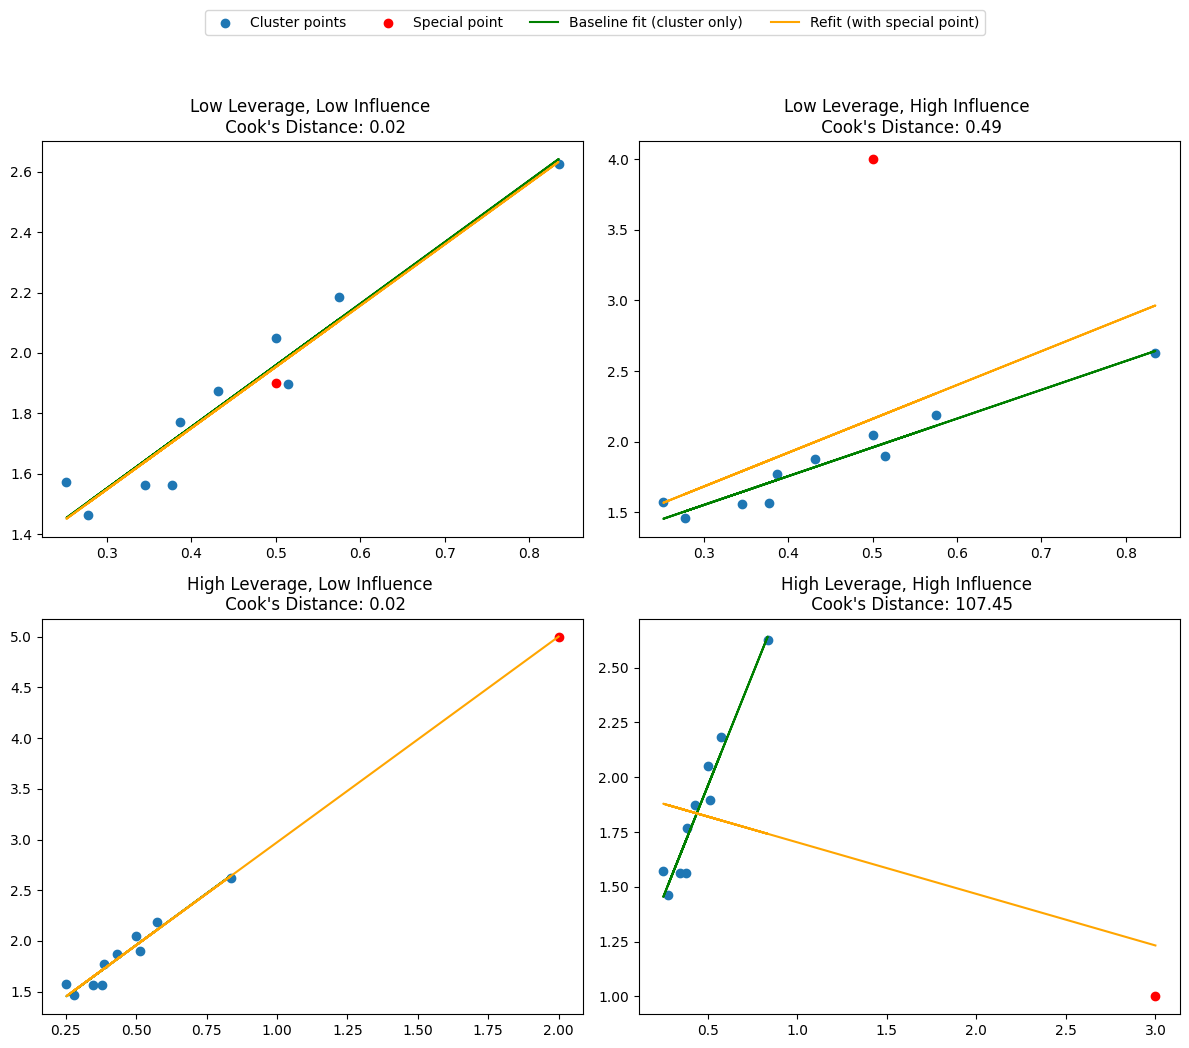

In [32]:
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

# Set random seed for reproducibility
rng = np.random.default_rng(7)

# Generate base cluster near the origin with a simple linear relationship y ≈ 2x + 1
n = 10
X_base = rng.normal(0.5, 0.25, size=n)
y_base = 2 * X_base + 1 + rng.normal(0, 0.1, size=n)

additional_points = {
    "Low Leverage, Low Influence": (0.5, 1.9),
    "Low Leverage, High Influence": (0.5, 4),
    "High Leverage, Low Influence": (2, 5),
    "High Leverage, High Influence": (3.0, 1.0)
}

fig, axes = plt.subplots(2, 2, figsize=(12, 10))
handles = []
labels = ['Cluster points', 'Special point', 'Baseline fit (cluster only)', 'Refit (with special point)']

for ax, (point_type, (x_new, y_new)) in zip(axes.flatten(), additional_points.items()):
    # Fit model without point
    Xb = sm.add_constant(X_base)
    model_base = sm.OLS(y_base, Xb).fit()
    intercept_base, slope_base = model_base.params

    # Fit model with new point
    X_all = np.concatenate([X_base, [x_new]])
    y_all = np.concatenate([y_base, [y_new]])
    Xa = sm.add_constant(X_all)
    model_all = sm.OLS(y_all, Xa).fit()
    intercept_all, slope_all = model_all.params

    # Compute Cook's Distance
    cooks_distances = model_all.get_influence().cooks_distance[0]
    cd_new_point = cooks_distances[-1]

    # Plotting
    h1 = ax.scatter(X_base, y_base)
    h2 = ax.scatter(x_new, y_new, color='red')
    h3, = ax.plot(X_base, intercept_base + slope_base * X_base, color='green')
    h4, = ax.plot(X_all, intercept_all + slope_all * X_all, color='orange')
    if not handles:
        handles = [h1, h2, h3, h4]
    ax.set_title(f"{point_type} \n Cook's Distance: {cd_new_point:.2f}")

# Add a single global legend
fig.legend(handles, labels, loc='upper center', ncol=4, bbox_to_anchor=(0.5, 1.05))
plt.tight_layout(rect=[0, 0, 1, 0.97])
